In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
#from sklearn import set_config

%matplotlib inline

# Dataset
"Naufrágio do Titanic". O objetivo é prever quais passageiros sobreviveriam ao desastre.

Fonte: https://paulovasconcellos.com.br/competicao-kaggle-titanic-tutorial-5b11993774f7

In [21]:
df = pd.read_csv("./data/train.csv")

# Pre-Processamento

- Removendo dados irrelevantes;
- Tratando valores nulos.

## Notas

As operações das linha comentadas no pre-processamento são tratadas diretamento pelo Pipeline.

In [22]:
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
#df['Age'] = np.floor(pd.to_numeric(df['Age'], errors='coerce')).astype('Int64')
#df['Age'].fillna(df['Age'].mean(), inplace = True)
#df['Age'] = df['Age'].astype(int)
#df['Embarked'].fillna('S', inplace = True)
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


- Pclass: Classe na qual o passageiro viajou;
- SibSp: Quantidade de irmãos e cônjuges a bordo;
- Parch: Quantidade de pais e filhos a bordo;
- Fare: Preço da passagem;
- Embarked: Indica o porto no qual o passageiro embarcou.
Cherbourg, Queenstown e Southampton, indicados pelas letras “C”, “Q” e “S”.

[Text(0, -20, '81'),
 Text(0, -20, '233'),
 Text(0, -20, '468'),
 Text(0, -20, '109')]

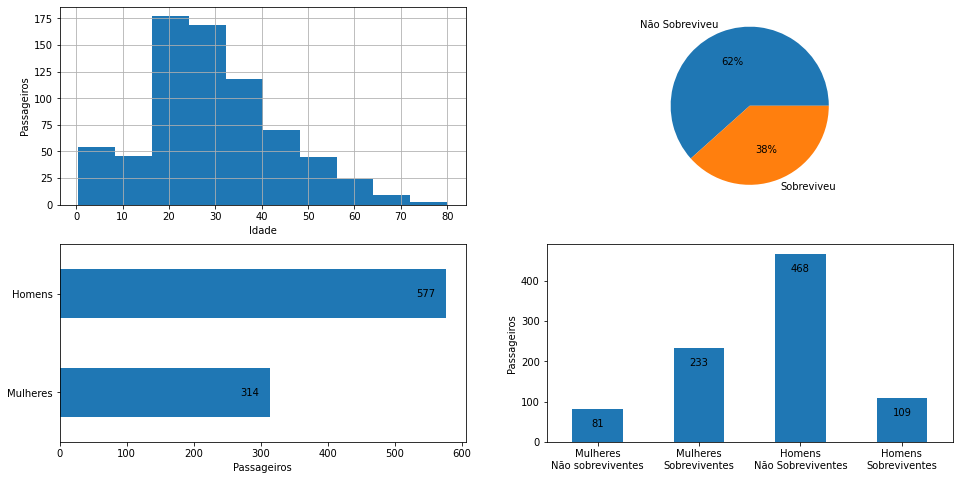

In [23]:
fig = plt.figure(figsize=(16,8))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax = df['Age'].hist()
ax.set_xlabel('Idade')
ax.set_ylabel('Passageiros')

ax = fig.add_subplot(2, 2, 2)
ax = df.groupby('Survived').size().plot.pie(
    autopct='%1.0f%%',
    labels=['Não Sobreviveu','Sobreviveu'])
ax.set_ylabel('')

ax = fig.add_subplot(2, 2, 3)
ax = df.groupby('Sex').size().plot.barh()
ax.set_yticklabels(['Mulheres', 'Homens'])
plt.bar_label(ax.containers[0], padding=-30)
ax.set_xlabel("Passageiros")
ax.set_ylabel("")

ax = fig.add_subplot(2, 2, 4)
ax = df.groupby(['Sex', 'Survived']).size().plot.bar()
ax.set_xticklabels([
    'Mulheres\nNão sobreviventes',
    'Mulheres\nSobreviventes',
    'Homens\nNão Sobreviventes',
    'Homens\nSobreviventes'])
ax.set_xlabel('')
ax.set_ylabel('Passageiros')
plt.xticks(rotation=0, ha='center')
plt.bar_label(ax.containers[0], padding=-20)


# Pipeline

- num_transformer, trata valores faltantes por imputação do valor médio;
- cat_transformer, one-hot encoder para variáveis categóricas.

In [24]:
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
cat_transformer = Pipeline(steps=[('one-hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, ['Age', 'Fare']),
    ('cat', cat_transformer, ['Sex', 'Embarked'])
])

In [25]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=3, random_state=0))
])


# Validando o Modelo

In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(model, X=df.drop(['Survived'], axis=1), y=df['Survived'], cv=kfold)
print('F1-Score: {} (mean)\nStd. Dev: {}'.format(
    results['test_score'].mean(),
    results['test_score'].std()))

F1-Score: 0.7811687904086371 (mean)
Std. Dev: 0.04352568674667897


# GridSearch

In [27]:
parameters = {
    'tree__max_depth': [3, 4, 5],
    'tree__criterion': ['gini', 'entropy'],
    'tree__splitter': ['best', 'random']
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True)
grid.fit(X=df.drop(['Survived'], axis=1), y=df['Survived'])

#grid.get_params().keys()
grid.best_params_

{'tree__criterion': 'gini', 'tree__max_depth': 5, 'tree__splitter': 'random'}

# Reconstruindo o Modelo com o grid.best_params_

In [28]:
df = pd.read_csv("./data/train.csv")
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
cat_transformer = Pipeline(steps=[('one-hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, ['Age', 'Fare']),
    ('cat', cat_transformer, ['Sex', 'Embarked'])
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(
        criterion='gini',
        splitter='random',
        max_depth=5,
        random_state=0))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(model, X=df.drop(['Survived'], axis=1), y=df['Survived'], cv=kfold)
print('F1-Score: {} (mean)\nStd. Dev: {}'.format(
    results['test_score'].mean(),
    results['test_score'].std()))


F1-Score: 0.7935095097608438 (mean)
Std. Dev: 0.03530037582488963
